<a href="https://colab.research.google.com/github/Nexus112/COSC420/blob/main/COSC420asgn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ktrain and eli5 install commands 


In [1]:
!pip3 install ktrain
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 4.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 58.7 MB/s 
     |████████████████████████████████| 263 kB 60.5 MB/s 
     |████████████████████████████████| 2.8 MB 61.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.5 MB/s 
     |████████████████████████████████| 468 kB 58.7 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 880 kB 63.7 MB/s 
     |████████████████████████████████| 3.3 MB 61.3 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=d104396a2b44de7701ee71976710ef198abe080aa4fe90cea5c669b3ac1fefb0
  Stored in directory: /root/.cache/pip/wheels/0a/b3/dd/512a01ea0b4f31d96163518b58361bb72d3bcb916d291052e7
  Cr

necesaary imports for running code

In [2]:
import io
import pandas as pd
import csv
import numpy as np
import os
from sklearn.model_selection import train_test_split
import ktrain
from ktrain import text
import eli5

sexism_data import directly into Google Colab

In [3]:
from google.colab import files
uploaded = files.upload()

Saving sexism_data.csv to sexism_data.csv


In [4]:
data = pd.read_csv('sexism_data.csv')

dataframe creation and splititng training and test data into numpy arrays 

In [5]:
df = pd.DataFrame({
    'text': data['text'].replace(r'\n\t', ' ', regex=True),
    'sexist': data['sexist']  
})

train,test = train_test_split(df, test_size=0.2)

In [6]:
x_train = train.text
y_train = train.sexist
x_test = test.text
y_test = test.sexist

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

full_text = df.text
full_text = full_text.to_numpy()

DistilBERT model used in creating the transformer t

In [7]:
MODEL_NAME =  'distilbert-base-uncased'

categories = ['False', 'True']

t = text.Transformer(MODEL_NAME, maxlen=200, classes= categories)

trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:490: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  "The class_names argument is replacing the classes argument. Please update your code."


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 25
	99percentile : 28


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 15
	95percentile : 25
	99percentile : 27


In [8]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Finding learning rate 

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1817/1817 [==============================] - 263s 144ms/step - loss: 0.1644 - accuracy: 0.9395
Epoch 2/2
1817/1817 [==============================] - 13s 7ms/step - loss: 0.4197 - accuracy: 0.8707


done.
Visually inspect loss plot and select learning rate associated with falling loss


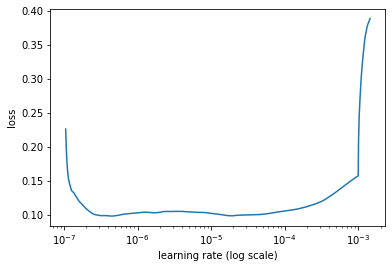

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

Fitting the classifier to the Data, parameters are the learning rate and the epochs 

In [9]:
learner.fit_onecycle(5e-5,5)



begin training using onecycle policy with max lr of 5e-05...
1818/1818 [==============================] - 292s 154ms/step - loss: 0.2201 - accuracy: 0.8982 - val_loss: 0.1798 - val_accuracy: 0.9215


Creating the predictor from the model

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

Predicting message by changing the message variable

In [12]:
message = "i hate men"
predictor.predict(message, return_proba=True)
predictor.explain(message)

Creating table to show the output of our classifier on the dataset

In [ ]:
preds = predictor.predict(full_text)
new_df = df.copy()
new_df['predicted_sexist'] = preds
new_df.head()

,text,sexist,predicted_sexist
0,MENTION3481 i didn't even know random was an o...,False,False
1,Bottom two should've gone! #mkr,False,False
2,MENTION3111 MENTION3424 ladyboner deserves so ...,False,False
3,She shall now be known as Sourpuss #MKR #KatAn...,False,False
4,Tarah W threw a bunch of women under the bus s...,False,False


Predicting the probabilities of all the text in the dataset

In [ ]:
probs = predictor.predict(full_text, return_proba=True)

Code for classifying the probabilites into borderline content ( using the range of < 0.7 and > 0.55)

In [ ]:
output_list = []
for i in range(len(probs)):
    prob_true = probs[i][1]
    if prob_true < 0.70 and prob_true > 0.55 :
      out = "Borderline"
    elif prob_true <= 0.55 : 
      out = "False"
    else:
      out = "True"
    output_list.append(out)

new_df["borderline_predict"] = output_list

Outputing cases of bporderline comments

In [ ]:
borderline_df = new_df[new_df['borderline_predict'] =="Borderline"]
borderline_df.head()

,text,sexist,predicted_sexist,borderline_predict
806,MENTION2263 They'll if you look at polls it's ...,False,True,Borderline
852,Act like a lady .. think like a man.. https://...,True,True,Borderline
964,it's harder for me to be mean to girls than it...,False,True,Borderline
1365,a game with a female as main character sucks,True,True,Borderline
1495,Women are much happier if they stay at home an...,True,True,Borderline
